In [2]:
import sys
import copy
import torch

from transformers import AutoTokenizer, AutoModelForCausalLM


In [ ]:
HOME_DIR = ".."

In [3]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [4]:
dtype = torch.bfloat16
torch.set_default_dtype(dtype)
torch.set_grad_enabled(False)
;

''

In [5]:
model = AutoModelForCausalLM.from_pretrained(
                                                    "meta-llama/Llama-3.2-1B"
                                                    # "meta-llama/Llama-3.2-3B"
                                                    # "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
                                                    # "JackFram/llama-160m"
                                            #  , attn_implementation="sdpa"
                                            , attn_implementation="flash_attention_2"
                                             ,torch_dtype=dtype)
model.eval()
model.lm_head = torch.nn.Identity()
# model.to('cuda');

# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


In [6]:
import sys
sys.path.append(f"{HOME_DIR}/associative-recurrent-memory-transformer")
sys.path.append(f"{HOME_DIR}")

from grouped_batching.llama1b_grouping import (
    wrap_model_with_armt
)

In [9]:
import time
import pandas as pd
import numpy as np
from tqdm import tqdm

# Define dimensions and batch sizes

hidden_size = model.config.hidden_size # llama-3.2-1B

seq_len = [512, 1024, 2048, 4096]
batch_sizes = range(1, 17)
# batch_sizes = [1, 2, 4, 8]
# batch_sizes = [1, 2, 3, 4, 5, 6, 7, 8]

In [10]:
SEQ_ARMT_MULTIPLIER = 1

def measure_computation_time_armt(armt_model, batch_size, seq_len, hidden_size, num_iterations=6):
    """
    Measure the computation time for a given model with specific hidden size and batch size.
    
    Args:
        model: The model to evaluate
        hidden_size: Size of the hidden dimension
        batch_size: Batch size for inference
        seq_len: Sequence length
        num_iterations: Number of iterations to average over
        
    Returns:
        float: Average computation time in milliseconds
    """
    # Create random input
    input_ids = torch.randint(
        0, 10000, 
        (batch_size, seq_len), 
        # dtype=torch.long, 
        device="cuda"
    )
    
    input_ids2 = torch.randint(
        0, 10000, 
        (batch_size, seq_len + seq_len*SEQ_ARMT_MULTIPLIER), 
        # dtype=torch.long, 
        device="cuda"
    )
    
    # Warm-up
    _ = armt_model.forward(input_ids)
    torch.cuda.synchronize()
    
    # Measure time
    times = []
    for _ in range(num_iterations):
        armt_model.memory_cell.zero_mem()
        start_time = time.time()
        _ = armt_model.forward(input_ids)
        torch.cuda.synchronize()
        end_time = time.time()
        times.append((end_time - start_time) * 1000)  # Convert to ms
        
    # Measure time
    times2 = []
    for _ in range(num_iterations):
        armt_model.memory_cell.zero_mem()
        start_time = time.time()
        _ = armt_model.forward(input_ids2)
        torch.cuda.synchronize()
        end_time = time.time()
        times2.append((end_time - start_time) * 1000)  # Convert to ms
    
    mean = (np.mean(times2) - np.mean(times))/SEQ_ARMT_MULTIPLIER
    std = np.sqrt((np.var(times2) + np.var(times) - 2 * np.cov(times2, times)[0, 1]) / SEQ_ARMT_MULTIPLIER)
    print(mean, std)
    return mean, std

In [11]:

# Create results dataframe
results_armt = pd.DataFrame(index=seq_len, columns=batch_sizes)
results_armt_std = pd.DataFrame(index=seq_len, columns=batch_sizes)

# Measure computation time for each combination
for seq_dim in tqdm(reversed(seq_len), desc="Hidden dimensions"):
    armt_config = dict(
        segment_size=seq_dim,
        num_mem_tokens=128,
        d_mem=64,
    )
    torch.manual_seed(0)
    use_armt_model = wrap_model_with_armt(copy.deepcopy(model).to('cpu'), **armt_config)
    use_armt_model.to("cuda")
    
    for batch in tqdm(reversed(batch_sizes), desc=f"Batch sizes for seq_len={seq_dim}", leave=False):
        mean, std = measure_computation_time_armt(use_armt_model, batch, seq_dim, hidden_size, num_iterations=2)
        results_armt.loc[seq_dim, batch] = mean/batch
        results_armt_std.loc[seq_dim, batch] = std/np.sqrt(batch)# per element. assume iid. Its not true, but we have no choice.
        
    del use_armt_model
    torch.cuda.empty_cache()

Hidden dimensions: 0it [00:00, ?it/s]

2672.452926635742 17.75111349783648


/tmp/ipykernel_481898/3591930337.py:57: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt((np.var(times2) + np.var(times) - 2 * np.cov(times2, times)[0, 1]) / SEQ_ARMT_MULTIPLIER)


2341.7208194732666 nan


2003.9315223693848 nan


1688.5044574737549 2.1573999249295603


1347.2740650177002 4.107698034453354


1022.7264165878296 7.271970055229299


680.4335117340088 9.243447433990838


Hidden dimensions: 1it [01:35, 95.88s/it]

366.35661125183105 4.15762173958195


1352.7899980545044 6.815737862539368


1193.8786506652832 3.6013609086785165


1019.9499130249023 0.833681317563563


858.9732646942139 1.423721111642911


697.6742744445801 nan


527.4996757507324 6.004562952077727


375.0349283218384 nan


Hidden dimensions: 2it [02:31, 72.49s/it]

195.44756412506104 1.0216843479601552


728.9693355560303 1.75619683703701


651.8367528915405 0.28854876330645357


537.2991561889648 0.16847237820705488


467.27192401885986 3.8747495997801003


383.29076766967773 0.9057929425708972


281.4769744873047 2.8727036391518492


209.50114727020264 4.884909983109183


Hidden dimensions: 3it [03:07, 55.72s/it]

112.74635791778564 0.6200593588566231


416.55445098876953 1.4734483650940713


389.346718788147 nan


332.10718631744385 3.6705955734073683


268.00405979156494 0.13304851557004777


224.52259063720703 3.8080744436052103


177.91175842285156 0.05042059741238046


127.04670429229736 0.22026318850083496


Hidden dimensions: 4it [03:33, 53.41s/it]

73.02677631378174 nan


In [11]:
results_armt

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
512,70.157925,37.801584,31.699419,29.944738,27.768501,28.091802,26.721182,26.461254,25.993956,25.627685,26.411541,25.230441,25.448701,24.586791,24.888044,24.163256
1024,63.086748,52.276572,47.305796,46.702623,46.529134,44.268211,45.10355,44.002801,44.692737,43.552947,43.665416,42.518602,43.140375,42.633301,43.050596,42.405183
2048,103.656292,93.047341,87.422636,85.889816,84.963131,83.391468,83.232687,82.99156,81.611916,81.303279,80.804334,80.603129,80.677894,82.768196,80.230024,80.307658
4096,189.899683,174.526334,168.191698,165.594618,165.858984,162.695924,162.431444,162.25792,162.065621,161.185606,163.641373,160.166389,160.071471,161.892653,160.007901,NaN


In [57]:
results_armt_std

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
512,10.308947,4.904785,4.213835,3.083261,1.33932,0.150985,NaN,0.034172,0.052356,39.30718,1.355277,0.19506,0.430942,0.159822,0.069855,0.057315
1024,2.309447,NaN,4.255253,1.014859,0.57315,0.353603,0.038942,0.045838,0.073711,0.07769,0.061654,0.037046,0.108982,0.303856,0.031839,0.06731
2048,4.216064,1.190251,0.255779,0.56958,0.224711,0.089689,0.081277,0.111998,0.212305,0.047065,0.080239,0.078464,0.623853,0.019601,0.043819,0.020638
4096,1.481394,0.205209,0.256534,0.047557,0.040554,0.201718,0.051691,0.051215,0.059286,0.051272,0.034631,0.048035,0.050844,0.060549,0.028714,0.061314


In [58]:
results_armt

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
512,31.219999,15.153805,8.204129,6.325463,5.351647,4.716886,4.040082,3.668423,3.354695,-2.170809,2.419804,2.722012,2.465062,2.391441,2.429398,2.37413
1024,25.461078,14.20631,9.510345,7.313848,6.085157,5.100687,4.596767,4.180183,4.265918,4.142769,3.992655,3.879362,3.918773,3.938896,3.792773,3.698617
2048,25.711616,14.606754,10.285748,8.380761,8.132871,7.637428,7.694494,7.32098,7.231695,7.124305,7.072908,6.986204,6.864456,6.875225,6.867894,6.788584
4096,27.404388,17.186622,16.010695,15.240341,14.787006,14.444033,14.260758,14.079695,13.945112,13.826799,13.745922,13.551017,13.514503,13.459634,13.445621,13.389274


In [12]:
# taken from 131072 context size column
measured_context_size = 131072
llama_seg_sizes = np.array([512, 1024, 2048, 4096])
num_segments = measured_context_size/llama_seg_sizes

# This numbers partially taken from the paper table (131072 context size column), 
# partially measured additionally,
# using usage_llama1b.ipynb
llama_160m = np.array([
    1.33,
    0.855,
    0.612,
    0.537
])

llama_1b = np.array([
    3.3,
    2.48,
    2.18,
    2.1
])

llama_3b = np.array([
    7.51,
    6.14,
    5.49,
    5.37,
])

llama_8b = np.array([
    15.2,
    12.6,
    11.5,
    11.1,
])

In [13]:
# use_measure = llama_160m*1000
# use_measure = llama_1b*1000
# use_measure = llama_3b*1000
use_measure = llama_8b*1000

achieved_scaling_per_segment = pd.DataFrame(use_measure/num_segments, index=seq_len, columns=["achieved_scaling_per_segment"])
achieved_scaling_per_segment

,achieved_scaling_per_segment
512,59.3750
1024,98.4375
2048,179.6875
4096,346.8750


In [14]:
llama_160m_amortized = pd.DataFrame(np.array([4.45, 5.541667, 8.5833334, 15.333334]), index=seq_len, columns=["lower_bound_scaling_per_segment"])
llama_1b_amortized = pd.DataFrame(np.array([10.5, 17.375, 31.6875, 64.3]), index=seq_len, columns=["lower_bound_scaling_per_segment"])
llama_3b_amortized = pd.DataFrame(np.array([22.214286, 41.785714, 83.035714, 170.7142857]), index=seq_len, columns=["lower_bound_scaling_per_segment"])
llama_8b_amortized = pd.DataFrame(np.array([43.4375, 85.208333,171.875, 353.125]), index=seq_len, columns=["lower_bound_scaling_per_segment"])

# lower_bound = llama_160m_amortized
# lower_bound = llama_1b_amortized
# lower_bound = llama_3b_amortized
lower_bound = llama_8b_amortized

In [34]:
num_segments

array([256., 128.,  64.,  32.])

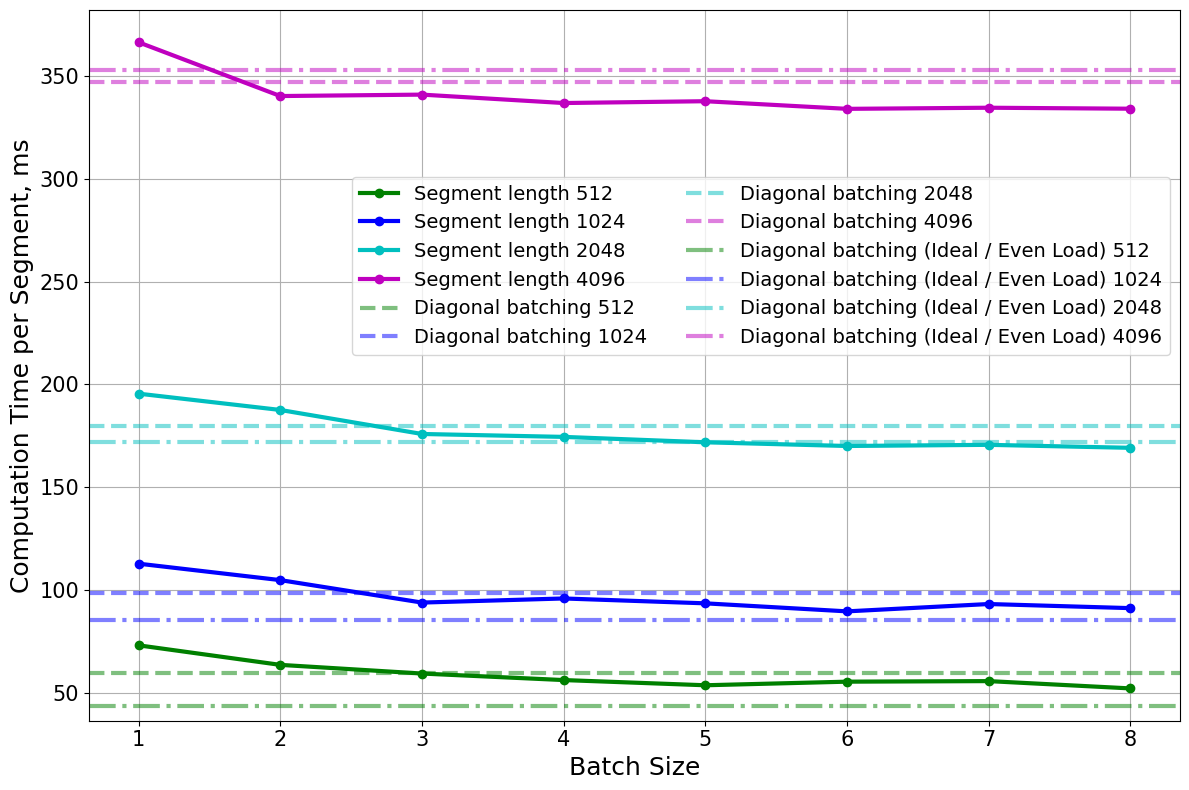

In [17]:
import matplotlib.pyplot as plt

# plot_results = results
plot_results = results_armt
plot_results_std = results_armt_std

# Plot the results with each hidden dimension as a separate line
plt.figure(figsize=(12, 8))

colors = ['g', 'b', 'c', 'm']

for i, dim in enumerate(seq_len):
    plt.plot(plot_results.columns, plot_results.loc[dim], marker='o', label=f'Segment length {dim}', color=colors[i], linewidth=3)
    
    # # Add 3 sigma borders using plot_results_std
    # plt.fill_between(
    #     plot_results.columns.astype(float),
    #     (plot_results.loc[dim] - 3 * plot_results_std.loc[dim] * np.sqrt(plot_results_std.columns)).astype(float),
    #     (plot_results.loc[dim] + 3 * plot_results_std.loc[dim] * np.sqrt(plot_results_std.columns)).astype(float),
    #     # (plot_results.loc[dim] - 3 * plot_results_std.loc[dim]).astype(float),
    #     # (plot_results.loc[dim] + 3 * plot_results_std.loc[dim]).astype(float),
    #     color=colors[i], alpha=0.2
    # )

# Add horizontal lines for achieved scaling per segment values
for i, dim in enumerate(seq_len):
    scaling_value = achieved_scaling_per_segment.loc[dim, 'achieved_scaling_per_segment']
    if scaling_value == 0:
        continue
    plt.axhline(y=scaling_value, color=colors[i], linestyle='--', 
                alpha=0.5, label=f'Diagonal batching {dim}', linewidth=3) # {scaling_value:.6f}

# Add horizontal lines for achieved scaling per segment values
for i, dim in enumerate(seq_len):
    scaling_value = lower_bound.loc[dim, 'lower_bound_scaling_per_segment']
    if scaling_value == 0:
        continue
    plt.axhline(y=scaling_value, color=colors[i], linestyle='-.', 
                alpha=0.5, label=f'Diagonal batching (Ideal / Even Load) {dim}', linewidth=3)




plt.xlabel('Batch Size', fontsize=18)
plt.ylabel('Computation Time per Segment, ms', fontsize=18)
# plt.title('Computation Time per Sample vs Batch Size for Different Hidden Dimensions')
# plt.legend(loc='center right', bbox_to_anchor=(1.0, 0.57), fontsize=14, ncol=2)
plt.legend(loc='center right', bbox_to_anchor=(1.0, 0.64), fontsize=14, ncol=2)
# plt.legend(loc='upper right', fontsize=15, ncol=2)
plt.grid(True)

plt.gca().tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.savefig(f'{HOME_DIR}/paper_pdfs/llama_8b_batch_vs_grouped_batching.pdf', bbox_inches='tight')
plt.show()
